In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [9]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [10]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [11]:
import os
import pickle
import pandas as pd
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# ------------------ CONFIG ------------------ #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
checkpoint_path = '/content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5'
final_model_path = '/content/drive/MyDrive/TEfficientNetV2B1_final.h5'
history_path = '/content/drive/MyDrive/TEfficientNetV2B1_history.pkl'
csv_log_path = '/content/drive/MyDrive/TEfficientNetV2B1_training_log.csv'

epochs = 15
batch_size = 32
input_shape = (240, 240, 3)  # Required shape for EfficientNetV2B1

# ------------- DYNAMIC EPOCH RESUME ---------------- #
start_epoch = 0
if os.path.exists(csv_log_path):
    try:
        df = pd.read_csv(csv_log_path)
        start_epoch = int(df['epoch'].iloc[-1]) + 1
        print(f"🔁 Resuming from epoch {start_epoch}")
    except Exception as e:
        print(f"⚠️ Could not read CSV log: {e}")

# --------------- DATASET ------------------- #
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

# ------------- LOAD OR CREATE MODEL -------------- #
if os.path.exists(checkpoint_path):
    print("📦 Loading model from checkpoint...")
    model = load_model(checkpoint_path)

    # ✅ Recompile after loading
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    print("🛠 Building new EfficientNetV2B1 model...")
    base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model for feature extraction

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ------------- CALLBACKS ----------------- #
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(csv_log_path, append=True)

# ------------- TRAIN --------------------- #
history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=start_epoch,
    epochs=epochs,
    callbacks=[checkpoint_callback, csv_logger]
)

# ------------- SAVE HISTORY -------------- #
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# ------------- FINAL MODEL SAVE ---------- #
model.save(final_model_path)
print("✅ Final model saved:", final_model_path)


⚠️ Could not read CSV log: No columns to parse from file
Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
🛠 Building new EfficientNetV2B1 model...
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7405 - loss: 0.5178
Epoch 1: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1492s 9s/step - accuracy: 0.7409 - loss: 0.5172 - val_accuracy: 0.9066 - val_loss: 0.2492
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8837 - loss: 0.2805
Epoch 2: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 642s 4s/step - accuracy: 0.8837 - loss: 0.2804 - val_accuracy: 0.9182 - val_loss: 0.1991
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9029 - loss: 0.2391
Epoch 3: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 678s 4s/step - accuracy: 0.9029 - loss: 0.2391 - val_accuracy: 0.9259 - val_loss: 0.1791
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9077 - loss: 0.2216
Epoch 4: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 635s 4s/step - accuracy: 0.9077 - loss: 0.2216 - val_accuracy: 0.9317 - val_loss: 0.1618
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9150 - loss: 0.2133
Epoch 5: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 613s 4s/step - accuracy: 0.9150 - loss: 0.2133 - val_accuracy: 0.9395 - val_loss: 0.1505
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9177 - loss: 0.1995
Epoch 6: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.9177 - loss: 0.1995 - val_accuracy: 0.9350 - val_loss: 0.1502
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9216 - loss: 0.1907
Epoch 7: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 704s 4s/step - accuracy: 0.9216 - loss: 0.1907 - val_accuracy: 0.9382 - val_loss: 0.1499
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9300 - loss: 0.1898
Epoch 8: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 639s 4s/step - accuracy: 0.9300 - loss: 0.1899 - val_accuracy: 0.9466 - val_loss: 0.1326
Epoch 9/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9244 - loss: 0.1919
Epoch 9: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 658s 4s/step - accuracy: 0.9244 - loss: 0.1919 - val_accuracy: 0.9459 - val_loss: 0.1397
Epoch 10/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9261 - loss: 0.1868
Epoch 10: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.9261 - loss: 0.1868 - val_accuracy: 0.9478 - val_loss: 0.1320
Epoch 11/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9262 - loss: 0.1803
Epoch 11: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 635s 4s/step - accuracy: 0.9262 - loss: 0.1803 - val_accuracy: 0.9491 - val_loss: 0.1304
Epoch 12/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9308 - loss: 0.1832
Epoch 12: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 691s 4s/step - accuracy: 0.9308 - loss: 0.1831 - val_accuracy: 0.9478 - val_loss: 0.1302
Epoch 13/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9284 - loss: 0.1802
Epoch 13: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 671s 4s/step - accuracy: 0.9284 - loss: 0.1802 - val_accuracy: 0.9524 - val_loss: 0.1228
Epoch 14/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9245 - loss: 0.1824
Epoch 14: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 0.9245 - loss: 0.1824 - val_accuracy: 0.9504 - val_loss: 0.1311
Epoch 15/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9331 - loss: 0.1672
Epoch 15: saving model to /content/drive/MyDrive/TEfficientNetV2B1_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.9330 - loss: 0.1673 - val_accuracy: 0.9543 - val_loss: 0.1181


✅ Final model saved: /content/drive/MyDrive/TEfficientNetV2B1_final.h5


In [12]:
import pickle

# ✅ Load training history for EfficientNetV2B1
with open('/content/drive/MyDrive/TEfficientNetV2B1_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Extract final epoch's training and validation accuracy
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc * 100:.2f}%")


✅ Final Training Accuracy: 92.70%
✅ Final Validation Accuracy: 95.43%


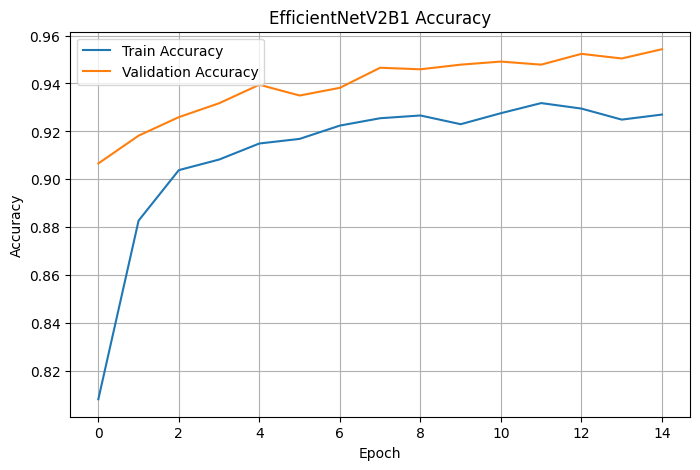

In [13]:
import matplotlib.pyplot as plt
import pickle

# ✅ Load training history for EfficientNetV2B1
with open('/content/drive/MyDrive/TEfficientNetV2B1_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetV2B1 Accuracy')  # Updated title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


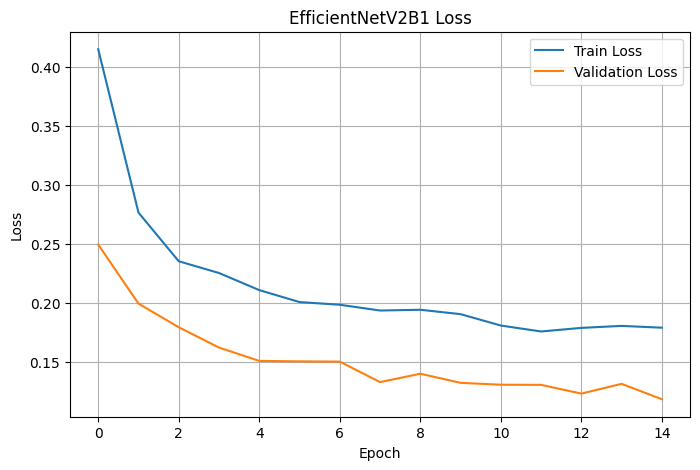

In [14]:
import matplotlib.pyplot as plt
import pickle

# ✅ Load training history for EfficientNetV2B1
with open('/content/drive/MyDrive/TEfficientNetV2B1_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('EfficientNetV2B1 Loss')  # Updated title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess

# -------- CONFIG -------- #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
final_model_path = '/content/drive/MyDrive/TEfficientNetV2B1_final.h5'  # 🔁 Updated for V2B1
batch_size = 32
input_shape = (240, 240, 3)  # 🔁 Updated input shape for EfficientNetV2B1

# -------- LOAD MODEL -------- #
model = load_model(final_model_path)

# -------- DATASET PREP -------- #
val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# -------- EVALUATE -------- #
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


Found 1556 images belonging to 2 classes.
49/49 ━━━━━━━━━━━━━━━━━━━━ 639s 13s/step - accuracy: 0.9406 - loss: 0.1608
✅ Test Accuracy: 95.37%
📉 Test Loss: 0.1264


49/49 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step
📊 Overall Model Performance (EfficientNetV2B1, Threshold = 0.50):

✅ Accuracy :  0.9537
🎯 Precision: 0.9734
🔁 Recall   : 0.9632
📈 F1 Score : 0.9683


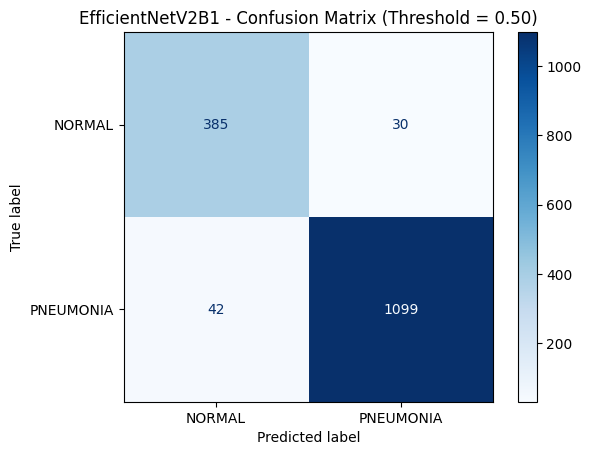


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1099
✅ True Negatives (TN): 385
❌ False Positives (FP): 30
❌ False Negatives (FN): 42


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# -------- Step 1: True labels from generator -------- #
y_true = test_generator.classes

# -------- Step 2: Model predictions -------- #
y_pred_probs = model.predict(test_generator, verbose=1)

# -------- Step 3: Apply threshold (e.g. 0.5) -------- #
threshold = 0.50
y_pred = (y_pred_probs > threshold).astype(int).reshape(-1)

# -------- Step 4: Metrics -------- #
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

# -------- Step 5: Print metrics -------- #
print("📊 Overall Model Performance (EfficientNetV2B1, Threshold = 0.50):\n")
print(f"✅ Accuracy :  {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# -------- Step 6: Confusion Matrix -------- #
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # e.g. ['NORMAL', 'PNEUMONIA']

# -------- Step 7: Plot Confusion Matrix -------- #
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("EfficientNetV2B1 - Confusion Matrix (Threshold = 0.50)")
plt.grid(False)
plt.show()

# -------- Step 8: TP, TN, FP, FN Breakdown -------- #
tn, fp, fn, tp = cm.ravel()

print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
